In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from networkx.algorithms import community as nx_comm
from itertools import combinations
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

In [11]:
df_x = pd.read_csv("x_train_Meacfjr.csv", delimiter=",", quotechar='"')

# Convert 'job_ids' and 'actions' from strings to actual lists
df_x["job_ids"] = df_x["job_ids"].apply(ast.literal_eval)
df_x["actions"] = df_x["actions"].apply(ast.literal_eval)

print(df_x.shape, df_x.columns)
print(df_x.info())
print(df_x.head(10))


(15882, 3) Index(['session_id', 'job_ids', 'actions'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15882 entries, 0 to 15881
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   session_id  15882 non-null  int64 
 1   job_ids     15882 non-null  object
 2   actions     15882 non-null  object
dtypes: int64(1), object(2)
memory usage: 372.4+ KB
None
   session_id                                      job_ids  \
0           0     [305, 299, 300, 290, 282, 274, 264, 261]   
1           1                          [84, 257, 252, 250]   
2           2          [241, 237, 221, 309, 310, 306, 301]   
3           3     [303, 297, 296, 298, 294, 295, 292, 293]   
4           4               [171, 291, 289, 166, 288, 155]   
5           5                         [286, 144, 284, 285]   
6           6                         [131, 283, 281, 279]   
7           7                              [277, 280, 275]   
8     

In [3]:
# Load the dataset without applying ast.literal_eval()
df_y = pd.read_csv("y_train_SwJNMSu.csv", delimiter=",", quotechar='"')

# Display the first 10 rows
print(df_y.head(10))

   session_id  job_id action
0           0      84   view
1           1     241   view
2           2     303  apply
3           3     171  apply
4           4     286  apply
5           5     131  apply
6           6     277  apply
7           7     276  apply
8           8     267  apply
9           9     259  apply


In [4]:
df_test = pd.read_csv("x_test_jCBBNP2.csv", delimiter=",", quotechar='"')

# Convert 'job_ids' and 'actions' from strings to actual lists
df_test["job_ids"] = df_test["job_ids"].apply(ast.literal_eval)
df_test["actions"] = df_test["actions"].apply(ast.literal_eval)

print(df_test.head(10))

   session_id                                            job_ids  \
0           0  [2393, 4794, 4822, 5160, 4229, 4951, 2188, 339...   
1           1  [1867, 2490, 3967, 2467, 5270, 4547, 4205, 223...   
2           2                                  [2449, 4317, 792]   
3           3  [4304, 2957, 3259, 2379, 2385, 357, 2908, 2241...   
4           4                 [2672, 2521, 3061, 783, 1512, 868]   
5           5  [1301, 663, 708, 105, 501, 497, 514, 701, 846,...   
6           6         [908, 2531, 700, 1836, 1157, 621, 653, 14]   
7           7                     [4451, 1785, 1885, 2263, 3014]   
8           8  [1902, 745, 504, 272, 433, 1136, 966, 3143, 30...   
9           9  [2231, 36, 929, 566, 2930, 2769, 1590, 1838, 2...   

                                             actions  
0  [view, view, view, view, view, view, view, vie...  
1  [view, view, view, view, view, apply, apply, a...  
2                                 [view, view, view]  
3  [view, view, view, apply, vi

## Analysis of the dataset

In [5]:
# Check for missing values in each column
print(df_x.isnull().sum())  # For x_train dataset
print(df_y.isnull().sum())  # For y_train dataset


session_id    0
job_ids       0
actions       0
dtype: int64
session_id    0
job_id        0
action        0
dtype: int64


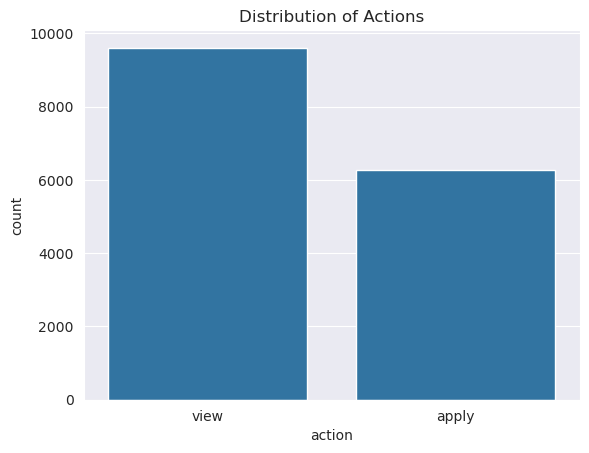

In [6]:
# Distribution of actions
sns.countplot(x='action', data=df_y)
plt.title('Distribution of Actions')
plt.show()

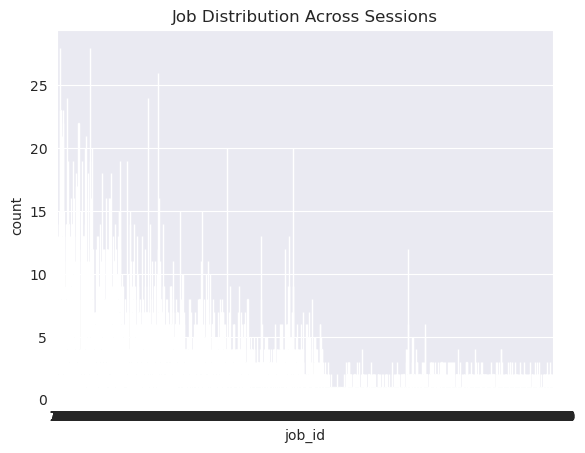

In [7]:
# Distribution of job_id across session_id
sns.countplot(x='job_id', data=df_y)
plt.title('Job Distribution Across Sessions')
plt.show()


In [8]:
# Exploding job_ids and actions columns
df_exploded = df_x.explode(['job_ids', 'actions'], ignore_index=True)

# Print the transformed dataframe
print(df_exploded)

        session_id job_ids actions
0                0     305    view
1                0     299    view
2                0     300    view
3                0     290    view
4                0     282    view
...            ...     ...     ...
119742       15880   27232    view
119743       15880   27231    view
119744       15881   27253    view
119745       15881   27252    view
119746       15881   27251    view

[119747 rows x 3 columns]


In [9]:

# ============================================================
# 0. Load Data
# ============================================================
# Update the paths below to match your data files.
df_x = pd.read_csv('/content/x_train_Meacfjr.csv')
df_y = pd.read_csv('/content/y_train_SwJNMSu.csv')

# Convert string representation of lists into actual lists
df_x["job_ids"] = df_x["job_ids"].apply(ast.literal_eval)
df_x["actions"] = df_x["actions"].apply(ast.literal_eval)


FileNotFoundError: [Errno 2] No such file or directory: '/content/x_train_Meacfjr.csv'

In [ ]:
# ============================================================
# 1. Exploratory Data Analysis (EDA)
# ============================================================

## 1.1 Session Characteristics: Session Length Distribution
df_x['session_length'] = df_x['job_ids'].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_x['session_length'], bins=20, kde=True)
plt.title("Session Length Distribution")
plt.xlabel("Number of Interactions (job_ids per session)")
plt.ylabel("Frequency")
plt.show()

## 1.2 Action Distribution: Frequency of “view” vs “apply”
# Flatten the list of actions
all_actions = [action for actions in df_x['actions'] for action in actions]
action_counts = pd.Series(all_actions).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=action_counts.index, y=action_counts.values, palette='pastel')
plt.title("Action Frequency in x_train")
plt.xlabel("Action")
plt.ylabel("Count")
plt.show()

## 1.3 Job Interaction Analysis: Popular Jobs
# For x_train: Count how many times each job appears across all sessions
all_jobs = [job for jobs in df_x['job_ids'] for job in jobs]
job_counts = pd.Series(all_jobs).value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=job_counts.index, y=job_counts.values, palette='viridis')
plt.title("Top 10 Popular Jobs in x_train")
plt.xlabel("Job ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# For y_train: Count the target job frequencies
job_counts_y = df_y['job_id'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=job_counts_y.index, y=job_counts_y.values, palette='magma')
plt.title("Top 10 Popular Jobs in y_train")
plt.xlabel("Job ID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## 1.4 Co-occurrence Analysis: Job Co-Interactions
# For each session, count each unique pair of job interactions.
co_occurrence = {}
for jobs in df_x['job_ids']:
    unique_jobs = list(set(jobs))
    for pair in combinations(unique_jobs, 2):
        pair = tuple(sorted(pair))
        co_occurrence[pair] = co_occurrence.get(pair, 0) + 1

co_occurrence_df = pd.DataFrame([{'job1': k[0], 'job2': k[1], 'count': v} for k, v in co_occurrence.items()])
top_pairs = co_occurrence_df.sort_values('count', ascending=False).head(20)
print("Top 20 co-occurring job pairs:")
print(top_pairs)

In [ ]:
# ============================================================
# 2. Sequential and Temporal Analysis
# ============================================================
# Example: Display and plot the order of interactions for a sample session.
sample_session = df_x.iloc[0]
print("\nSample Session ID:", sample_session['session_id'])
print("Job Sequence:", sample_session['job_ids'])
print("Action Sequence:", sample_session['actions'])

# Plot the job sequence (using indices as x-axis since job IDs may be non-numeric)
plt.figure(figsize=(8, 4))
plt.plot(range(len(sample_session['job_ids'])), sample_session['job_ids'], marker='o')
plt.title(f"Job Sequence for Session {sample_session['session_id']}")
plt.xlabel("Interaction Order")
plt.ylabel("Job ID")
plt.xticks(range(len(sample_session['job_ids'])))
plt.show()

In [ ]:
# ============================================================
# 3. Graph and Network Analysis
# ============================================================
## 3.1 Build a Bipartite Graph (Sessions and Jobs)
B = nx.Graph()

# To avoid ID collisions, prefix session IDs with 's_' and job IDs with 'j_'
for _, row in df_x.iterrows():
    session_node = f"s_{row['session_id']}"
    B.add_node(session_node, bipartite=0)
    for job in row['job_ids']:
        job_node = f"j_{job}"
        B.add_node(job_node, bipartite=1)
        B.add_edge(session_node, job_node)

# Degree distributions
session_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
job_nodes = set(B) - session_nodes

session_degrees = [B.degree(n) for n in session_nodes]
job_degrees = [B.degree(n) for n in job_nodes]

plt.figure(figsize=(8, 4))
sns.histplot(session_degrees, kde=True, bins=20, color='skyblue')
plt.title("Degree Distribution for Sessions")
plt.xlabel("Degree (Number of Job Interactions)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(job_degrees, kde=True, bins=20, color='salmon')
plt.title("Degree Distribution for Jobs")
plt.xlabel("Degree (Number of Sessions Interacting)")
plt.ylabel("Frequency")
plt.show()

## 3.2 Community Detection using Girvan-Newman Algorithm
# Note: Girvan-Newman can be computationally intensive for large graphs.
comp = nx_comm.girvan_newman(B)
first_level_communities = tuple(sorted(c) for c in next(comp))
print("\nDetected communities (first level) using Girvan-Newman:")
for i, community in enumerate(first_level_communities):
    print(f"Community {i+1}: {community}")


In [ ]:
# Alternative community detection using Greedy Modularity
communities = nx_comm.greedy_modularity_communities(B)

print("\nDetected communities using Greedy Modularity:")
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

In [ ]:
# ============================================================
# 4. Latent Factor and Clustering Analysis
# ============================================================
## 4.1 Build the Interaction Matrix
def build_interaction_matrix(x_train, weight_map={'apply': 2, 'view': 1}):
    sessions = x_train['session_id'].unique()
    all_jobs = set()
    for jobs in x_train['job_ids']:
        all_jobs.update(jobs)
    all_jobs = list(all_jobs)

    session2idx = {s: i for i, s in enumerate(sessions)}
    job2idx = {j: i for i, j in enumerate(all_jobs)}

    matrix = np.zeros((len(sessions), len(all_jobs)))
    for _, row in x_train.iterrows():
        s_idx = session2idx[row['session_id']]
        for job, act in zip(row['job_ids'], row['actions']):
            j_idx = job2idx[job]
            matrix[s_idx, j_idx] += weight_map.get(act, 1)
    return matrix, session2idx, job2idx

interaction_matrix, session2idx, job2idx = build_interaction_matrix(df_x)

## 4.2 Matrix Factorization via SVD
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(interaction_matrix)  # Session latent factors
job_factors = svd.components_.T                       # Job latent factors

## 4.3 Visualize the Latent Space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
user_tsne = tsne.fit_transform(user_factors)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=user_tsne[:, 0], y=user_tsne[:, 1])
plt.title("t-SNE of Session Latent Factors")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

## 4.4 K-Means Clustering on Session Latent Factors
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(user_factors)
sil_score = silhouette_score(user_factors, clusters)
print(f"\nSilhouette Score for K-Means clustering (k=5): {sil_score:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=user_tsne[:, 0], y=user_tsne[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title("t-SNE Visualization with K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Cluster")
plt.show()

In [ ]:
# ============================================================
# 5. Predictive Model Analysis: Next-Action Prediction
# ============================================================
## 5.1 Feature Engineering: Build Session Features
def build_session_features(x_train):
    features = []
    session_ids = []
    for _, row in x_train.iterrows():
        s_id = row['session_id']
        total = len(row['actions'])
        count_apply = row['actions'].count('apply')
        count_view = row['actions'].count('view')
        features.append([total, count_apply, count_view])
        session_ids.append(s_id)
    feature_df = pd.DataFrame(features, columns=['total', 'apply_count', 'view_count'])
    feature_df['session_id'] = session_ids
    return feature_df

session_features = build_session_features(df_x)
data_model = pd.merge(session_features, df_y, on='session_id', how='inner')

# Prepare features and target (encode 'apply' as 1, 'view' as 0)
X = data_model[['total', 'apply_count', 'view_count']]
y = data_model['action'].apply(lambda x: 1 if x == 'apply' else 0)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X, y)

print("\nLogistic Regression Feature Coefficients:")
coeff_df = pd.Series(clf.coef_[0], index=X.columns)
print(coeff_df)

## 5.2 Error Analysis: Confusion Matrix
y_pred = clf.predict(X)
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Next-Action Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 5.3 Evaluation Metric Analysis: Recommendation MRR
def predict_session(session_idx, user_factors, job_factors, interaction_matrix, top_n=10):
    scores = user_factors[session_idx].dot(job_factors.T)
    # Exclude already-interacted jobs
    scores[interaction_matrix[session_idx] > 0] = -np.inf
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return top_indices

# Prepare mapping from job index back to job ID
idx2job = {i: j for j, i in job2idx.items()}

# Compute reciprocal ranks for each session in df_y
reciprocal_ranks = []
for _, row in df_y.iterrows():
    s_id = row['session_id']
    if s_id in session2idx:
        s_idx = session2idx[s_id]
        top_indices = predict_session(s_idx, user_factors, job_factors, interaction_matrix, top_n=10)
        recommended_jobs = [idx2job[i] for i in top_indices]
        # Calculate reciprocal rank
        try:
            rank = recommended_jobs.index(row['job_id']) + 1
            rr = 1.0 / rank
        except ValueError:
            rr = 0.0
        reciprocal_ranks.append(rr)

plt.figure(figsize=(6, 4))
sns.boxplot(y=reciprocal_ranks, color='lightgreen')
plt.title("Distribution of Reciprocal Ranks (MRR) for Recommendations")
plt.ylabel("Reciprocal Rank")
plt.show()

mrr = np.mean(reciprocal_ranks)
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")

# Also, display next-action prediction accuracy
action_accuracy = accuracy_score(y, y_pred)
print(f"Next-Action Prediction Accuracy: {action_accuracy:.4f}")

In [ ]:
# ============================================================
# 6. User Behavior Segmentation
# ============================================================
# Segment users based on session features
kmeans_seg = KMeans(n_clusters=3, random_state=42)
session_features['segment'] = kmeans_seg.fit_predict(session_features[['total', 'apply_count', 'view_count']])

print("\nUser Segmentation (Session Behavior) Summary:")
print(session_features.groupby('segment').mean())

plt.figure(figsize=(8, 6))
sns.boxplot(x='segment', y='total', data=session_features, palette='Set3')
plt.title("Session Total Interactions by Segment")
plt.xlabel("Segment")
plt.ylabel("Total Interactions")
plt.show()

## Collaborative filtering

In [ ]:
# ---------------------------
# 2. Build the Interaction Matrix (Collaborative Filtering)
# ---------------------------
def build_interaction_matrix(x_train, weight_map={'apply': 5, 'view': 1}):
    """
    Create a user-item interaction matrix with weights based on action type.
    """
    sessions = x_train['session_id'].unique()

    # Extract unique job IDs
    all_jobs = set()
    for jobs in x_train['job_ids']:
        all_jobs.update(jobs)
    all_jobs = list(all_jobs)

    # Mapping dictionaries
    session2idx = {s: i for i, s in enumerate(sessions)}
    job2idx = {j: i for i, j in enumerate(all_jobs)}

    # Initialize interaction matrix
    matrix = np.zeros((len(sessions), len(all_jobs)))

    # Populate the matrix
    for _, row in x_train.iterrows():
        s_idx = session2idx[row['session_id']]
        for job, act in zip(row['job_ids'], row['actions']):
            j_idx = job2idx[job]
            matrix[s_idx, j_idx] += weight_map.get(act, 1)

    return matrix, session2idx, job2idx

interaction_matrix, session2idx, job2idx = build_interaction_matrix(df_x)

# ---------------------------
# 3. Apply SVD for Collaborative Filtering
# ---------------------------
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(interaction_matrix)  # Session representations
job_factors = svd.components_.T                      # Job representations

def predict_session(session_idx, user_factors, job_factors, interaction_matrix, top_n=10):
    """
    Generate top-N job recommendations for a given session.
    """
    scores = user_factors[session_idx].dot(job_factors.T)
    scores[interaction_matrix[session_idx] > 0] = -np.inf  # Exclude seen jobs
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return top_indices

# ---------------------------
# 4. Next-Action Prediction (Logistic Regression)
# ---------------------------
def build_session_features(x_train):
    """
    Extract session-level features based on action history.
    """
    features = []
    session_ids = []

    for _, row in x_train.iterrows():
        s_id = row['session_id']
        actions = row['actions']
        features.append([len(actions), actions.count('apply'), actions.count('view')])
        session_ids.append(s_id)

    feature_df = pd.DataFrame(features, columns=['total', 'apply_count', 'view_count'])
    feature_df['session_id'] = session_ids
    return feature_df

session_features = build_session_features(df_x)
data = pd.merge(session_features, df_y, on='session_id', how='inner')

# Prepare features and labels
X = data[['total', 'apply_count', 'view_count']]
y = data['action'].apply(lambda x: 1 if x == 'apply' else 0)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X, y)

# ---------------------------
# 5. Generate Recommendations & Predictions
# ---------------------------
results = {}
idx2job = {i: j for j, i in job2idx.items()}

y_true_jobs = []  # Store actual next job interactions
y_pred_jobs = []  # Store predicted job lists

y_true_actions = []  # Store actual actions
y_pred_actions = []  # Store predicted actions

for _, row in df_y.iterrows():
    s_id = row['session_id']

    if s_id in session2idx:
        s_idx = session2idx[s_id]
        top_indices = predict_session(s_idx, user_factors, job_factors, interaction_matrix, top_n=10)
        recommended_jobs = [idx2job[i] for i in top_indices]

        # Store for MRR calculation
        y_true_jobs.append(row['job_id'])
        y_pred_jobs.append(recommended_jobs)

        # Predict next action (Fixed)
        feat = session_features[session_features['session_id'] == s_id][['total', 'apply_count', 'view_count']]
        if not feat.empty:
            predicted_action = clf.predict(feat)[0]  # No warnings
            predicted_action = 'apply' if predicted_action == 1 else 'view'
        else:
            predicted_action = 'view'  # Default fallback

        y_true_actions.append(row['action'])
        y_pred_actions.append(predicted_action)


# ---------------------------
# 6. Evaluation Metrics: MRR & Accuracy
# ---------------------------
def mean_reciprocal_rank(y_true, y_pred, k=10):
    """
    Compute Mean Reciprocal Rank (MRR) at K.
    """
    rr_sum = 0.0
    for true_job, pred_jobs in zip(y_true, y_pred):
        try:
            rank = pred_jobs.index(true_job) + 1
            rr_sum += 1.0 / rank
        except ValueError:
            rr_sum += 0.0  # Not in top-k

    return rr_sum / len(y_true)

def compute_final_score(mrr, accuracy):
    """
    Compute the final score as:
      70% MRR + 30% Accuracy
    """
    return (0.7 * mrr) + (0.3 * accuracy)

# Calculate MRR
mrr_score = mean_reciprocal_rank(y_true_jobs, y_pred_jobs)

# Calculate Accuracy
action_accuracy = accuracy_score([1 if x == 'apply' else 0 for x in y_true_actions],
                                 [1 if x == 'apply' else 0 for x in y_pred_actions])

# Compute final weighted score
final_score = compute_final_score(mrr_score, action_accuracy)

print("\nEvaluation Results:")
print(f"  🔹 MRR Score: {mrr_score:.4f}")
print(f"  🔹 Action Prediction Accuracy: {action_accuracy:.4f}")
print(f"  🔹 Final Score (70% MRR + 30% Accuracy): {final_score:.4f}")

# ---------------------------
# 7. Clustering & Visualization
# ---------------------------
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
session_clusters = kmeans.fit_predict(user_factors)

session_cluster_df = pd.DataFrame({'session_id': list(session2idx.keys()), 'cluster': session_clusters})
session_plot_df = pd.merge(session_features, session_cluster_df, on='session_id')

tsne = TSNE(n_components=2, random_state=42)
user_tsne = tsne.fit_transform(user_factors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_tsne[:, 0], y=user_tsne[:, 1], hue=session_clusters, palette='viridis', legend='full')
plt.title("Session Clusters via t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()


In [ ]:

# ---------------------------
# 1. Load Data
# ---------------------------
df_x = pd.read_csv('/content/x_train_Meacfjr.csv')
df_y = pd.read_csv('/content/y_train_SwJNMSu.csv')

# Convert 'job_ids' and 'actions' from strings to actual lists
df_x["job_ids"] = df_x["job_ids"].apply(ast.literal_eval)
df_x["actions"] = df_x["actions"].apply(ast.literal_eval)

# ---------------------------
# 2. Build the Interaction Matrix (Collaborative Filtering)
# ---------------------------
def build_interaction_matrix(x_train, weight_map={'apply': 5, 'view': 1}):
    """
    Create a user-item interaction matrix with weights based on action type.
    """
    sessions = x_train['session_id'].unique()

    # Extract unique job IDs
    all_jobs = set()
    for jobs in x_train['job_ids']:
        all_jobs.update(jobs)
    all_jobs = list(all_jobs)

    # Mapping dictionaries
    session2idx = {s: i for i, s in enumerate(sessions)}
    job2idx = {j: i for i, j in enumerate(all_jobs)}

    # Initialize interaction matrix
    matrix = np.zeros((len(sessions), len(all_jobs)))

    # Populate the matrix
    for _, row in x_train.iterrows():
        s_idx = session2idx[row['session_id']]
        for job, act in zip(row['job_ids'], row['actions']):
            j_idx = job2idx[job]
            matrix[s_idx, j_idx] += weight_map.get(act, 1)

    return matrix, session2idx, job2idx

interaction_matrix, session2idx, job2idx = build_interaction_matrix(df_x)

# ---------------------------
# 3. Apply SVD for Collaborative Filtering
# ---------------------------
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(interaction_matrix)  # Session representations
job_factors = svd.components_.T                      # Job representations

def predict_session(session_idx, user_factors, job_factors, interaction_matrix, top_n=10):
    """
    Generate top-N job recommendations for a given session.
    """
    scores = user_factors[session_idx].dot(job_factors.T)
    scores[interaction_matrix[session_idx] > 0] = -np.inf  # Exclude seen jobs
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return top_indices

# ---------------------------
# 4. Next-Action Prediction (Logistic Regression)
# ---------------------------
def build_session_features(x_train):
    """
    Extract session-level features based on action history.
    """
    features = []
    session_ids = []

    for _, row in x_train.iterrows():
        s_id = row['session_id']
        actions = row['actions']
        features.append([len(actions), actions.count('apply'), actions.count('view')])
        session_ids.append(s_id)

    feature_df = pd.DataFrame(features, columns=['total', 'apply_count', 'view_count'])
    feature_df['session_id'] = session_ids
    return feature_df

session_features = build_session_features(df_x)
data = pd.merge(session_features, df_y, on='session_id', how='inner')

# Prepare features and labels
X = data[['total', 'apply_count', 'view_count']]
y = data['action'].apply(lambda x: 1 if x == 'apply' else 0)

# Train logistic regression
clf = LogisticRegression()
clf.fit(X, y)

# ---------------------------
# 5. Generate Recommendations & Predictions
# ---------------------------
results = {}
idx2job = {i: j for j, i in job2idx.items()}

y_true_jobs = []  # Store actual next job interactions
y_pred_jobs = []  # Store predicted job lists

y_true_actions = []  # Store actual actions
y_pred_actions = []  # Store predicted actions

for _, row in df_y.iterrows():
    s_id = row['session_id']

    if s_id in session2idx:
        s_idx = session2idx[s_id]
        top_indices = predict_session(s_idx, user_factors, job_factors, interaction_matrix, top_n=10)
        recommended_jobs = [idx2job[i] for i in top_indices]

        # Store for MRR calculation
        y_true_jobs.append(row['job_id'])
        y_pred_jobs.append(recommended_jobs)

        # Predict next action (Fixed)
        feat = session_features[session_features['session_id'] == s_id][['total', 'apply_count', 'view_count']]
        if not feat.empty:
            predicted_action = clf.predict(feat)[0]  # No warnings
            predicted_action = 'apply' if predicted_action == 1 else 'view'
        else:
            predicted_action = 'view'  # Default fallback

        y_true_actions.append(row['action'])
        y_pred_actions.append(predicted_action)


# ---------------------------
# 6. Evaluation Metrics: MRR & Accuracy
# ---------------------------
def mean_reciprocal_rank(y_true, y_pred, k=10):
    """
    Compute Mean Reciprocal Rank (MRR) at K.
    """
    rr_sum = 0.0
    for true_job, pred_jobs in zip(y_true, y_pred):
        try:
            rank = pred_jobs.index(true_job) + 1
            rr_sum += 1.0 / rank
        except ValueError:
            rr_sum += 0.0  # Not in top-k

    return rr_sum / len(y_true)

def compute_final_score(mrr, accuracy):
    """
    Compute the final score as:
      70% MRR + 30% Accuracy
    """
    return (0.7 * mrr) + (0.3 * accuracy)

# Calculate MRR
mrr_score = mean_reciprocal_rank(y_true_jobs, y_pred_jobs)

# Calculate Accuracy
action_accuracy = accuracy_score([1 if x == 'apply' else 0 for x in y_true_actions],
                                 [1 if x == 'apply' else 0 for x in y_pred_actions])

# Compute final weighted score
final_score = compute_final_score(mrr_score, action_accuracy)

print("\nEvaluation Results:")
print(f"  🔹 MRR Score: {mrr_score:.4f}")
print(f"  🔹 Action Prediction Accuracy: {action_accuracy:.4f}")
print(f"  🔹 Final Score (70% MRR + 30% Accuracy): {final_score:.4f}")

# ---------------------------
# 7. Clustering & Visualization
# ---------------------------
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
session_clusters = kmeans.fit_predict(user_factors)

session_cluster_df = pd.DataFrame({'session_id': list(session2idx.keys()), 'cluster': session_clusters})
session_plot_df = pd.merge(session_features, session_cluster_df, on='session_id')

tsne = TSNE(n_components=2, random_state=42)
user_tsne = tsne.fit_transform(user_factors)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=user_tsne[:, 0], y=user_tsne[:, 1], hue=session_clusters, palette='viridis', legend='full')
plt.title("Session Clusters via t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()


In [ ]:
!pip install plotly --quiet

In [ ]:
import plotly.express as px

# Assuming user_factors and session_clusters have been computed previously.
tsne_3d = TSNE(n_components=3, random_state=42)
user_tsne_3d = tsne_3d.fit_transform(user_factors)

# Create a DataFrame for Plotly
df_plot = pd.DataFrame(user_tsne_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df_plot['cluster'] = session_clusters

fig = px.scatter_3d(df_plot, x='Dim1', y='Dim2', z='Dim3', color='cluster',
                    title='Session Clusters via 3D t-SNE (Interactive)')
fig.show()
